# Portfolio analysis
This notebook introduces the concept of portfolio-level analyses. In this notebook, the results of the asset-level analysis are translated into firm-level results which are subsequently translated into portfolio-level results.

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from prisk.utils import extract_firms, link_basins, convert_to_continous_damage
from prisk.portfolio import Portfolio
from prisk.plotting import plot_assets_and_basins, compare_value_distributions, visualize_dependency_models, analyze_bootstrap_stability, compare_risk_models, generate_summary_table
from prisk.run_simulation import run_simulation

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
random_seed=0

insurer_capital = 2e9
flood_protection = 100
simulations = 10
return_period_columns = [5, 10, 25, 50, 100, 200, 500, 1000]

country = "Thailand" # "India" or "Thailand"
copula = "vine" # None or "gaussian" or "vine" or "t" or "complete_dependent"

All files for the analysis must be pre-downloaded, by running the script Data/download_app_files.py


In [3]:
power = pd.read_excel("../Data/app/power.xlsx")
hybas_basins_file = "../Data/app/hybas_as_lev06_v1c.shp"
basins = gpd.read_file(hybas_basins_file)

if country == "India":
    basin_outlet_file = "../Data/app/HA_L6_outlets_India_constrained.csv"
elif country == "Thailand":
    basin_outlet_file = "../Data/app/lev06_outlets_final_clipped_Thailand_no_duplicates.csv"
country_basins = pd.read_csv(basin_outlet_file).HYBAS_ID.to_list()

In [4]:
if country == "India":
    financial_data_file = "../Data/app/Indian_firms.xlsx"
elif country == "Thailand":
    financial_data_file = "../Data/app/financial_data.xlsx"
    
financial_data = pd.read_excel(financial_data_file)  # Load damage curves

# standardize Thailand financial data
if country == "Thailand":
    financial_data["clean"] = financial_data["name"]
    financial_data = financial_data.rename(columns={"Leverage ratio":"Leverage Ratio"})

firm_mapping = {
        row["name"]: row["clean"]
        for _, row in financial_data[["name", "clean"]].iterrows()
    }

median_ratio = financial_data["Leverage Ratio"].median()
financial_data["Leverage Ratio"].fillna(median_ratio, inplace=True)

leverage_ratios = {
        firm: leverage
        for firm, leverage in zip(
            financial_data["clean"], financial_data["Leverage Ratio"]
        )
    }

Load and process damage curves

In [5]:
damage_curves_file = "../Data/app/damage_curves.xlsx"
damage_curves = pd.read_excel(damage_curves_file)  # Load damage curves
continuous_curves = convert_to_continous_damage(
    damage_curves
)

The files containing the randomly generated samples can be generated using the notebooks found in the Exploratory analysis folder. Alternatively, they can be downloaded from the link in the package README.md file.

In [6]:

if country == "India":
    gaussian_random_numbers = pd.read_parquet("../Data/app/gaussian_random_numbers_cooccurrence_india.parquet.gzip")
    t_random_numbers = pd.read_parquet("../Data/t_random_numbers_cooccurrence_india.parquet.gzip")
    vine_random_numbers = pd.read_parquet("../Data/vine_random_numbers_cooccurrence_india.parquet.gzip")
    uniform_random_numbers = pd.read_parquet("../Data/uniform_random_numbers_india.parquet.gzip")
    complete_dependent_random_numbers = pd.read_parquet("../Data/complete_dependent_random_numbers_india.parquet.gzip")
elif country == "Thailand":
    gaussian_random_numbers = pd.read_parquet("../Data/gaussian_random_numbers_cooccurrence.parquet.gzip")
    t_random_numbers = pd.read_parquet("../Data/t_random_numbers_cooccurrence.parquet.gzip")
    vine_random_numbers = pd.read_parquet("../Data/vine_random_numbers_cooccurrence.parquet.gzip")
    uniform_random_numbers = pd.read_parquet("../Data/uniform_random_numbers.parquet.gzip")
    complete_dependent_random_numbers = pd.read_parquet("../Data/complete_dependent_random_numbers.parquet.gzip")
    
if copula is None:
    random_numbers = uniform_random_numbers
elif copula == "gaussian":
    random_numbers = gaussian_random_numbers
elif copula == "vine":
    random_numbers = vine_random_numbers
elif copula == "t":
    random_numbers = t_random_numbers
elif copula == "complete_dependent":
    random_numbers = complete_dependent_random_numbers

##### Extracting Agents
The P-RISK model is based on asset-level analyses that are subsequently translated into firm- and portfolio-level impacts. To extract the firms from the Global Energy Monitor database, we use a utility function. If this approach is applied on a different dataset, then the extract_firms function needs to be replaced. We assume flood protection levels (consistent with other literature).

We limit the analysis to a single country.

In [7]:
assets = power[power["Country"] == country].copy().reset_index(drop=True).drop(columns=[2])
assets.loc[:, "flood_protection"] = assets[flood_protection]
firms, assets_processed = extract_firms(
        assets,
        return_period_columns=return_period_columns,
        firm_mapping=firm_mapping,
        leverage_ratios=leverage_ratios,
        damage_curves=continuous_curves
        )

##### Portfolio construction
The portfolio consists of the firms linked to the assets located in Thailand. We assume an equal weighted portfolio:

In [8]:
portfolio = Portfolio(f"{country} power assets")
nav = 1
for firm in firms:
    portfolio.add_position(firm, nav/(len(firms)*firm.npv))                    

# Conduct simulation
The prisk simulations are still performed at the asset-level but due to the set-up with python classes, the results can easily be analysed at the portfolio-level. In each notebook, we perform multiple versions of the prisk framework that differentiate in the dependency modelling framework that was used. The five frameworks are:
1. **Completely independent events**: each asset has independent flood events that occur.
2. **Basin-level dependence**: floods are simulated at the basin-level. Whenever a flood occurs in a basin, all assets located inside that basin are affected. The floods between basins are assumed to be independent.
3. **Complete dependence**: the dependency of floods between basins are modelled using three copula functions: (1) gaussian copula, (2) the t-copula, and (3) the vine copula.

At the beginning of each of the model cells, we set the random seed. This ensures that the results are (1) completely reproducible, (2) perfectly compareable across different notebook versions (robustness checks), and (3) perfectly comparable across different dependency modelling approaches.


## 1. Complete independence

### Kernel insurance

In [9]:
# Scenario 1: Complete Independence without Insurance
sim_result = run_simulation(
    random_numbers=None,  # No copula applied
    assets_df=assets_processed,        # Independent assets
    firms=firms,
    portfolio=portfolio,
    simulations=simulations,
    time_horizon=25,
    seed=random_seed,
    insured=False,                # No insurance
    insurer_capital=insurer_capital,
    dropout_time=None,            # No dropout
    calculate_pds=False          # No PD calculations
)

# Extract portfolio values
portfolio_values = sim_result["portfolio_values"]


Simulating No Copula: 100%|██████████| 10/10 [00:00<00:00, 11.45it/s]


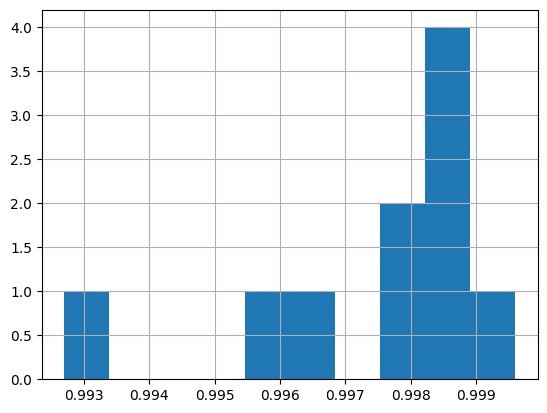

In [10]:
pd.Series(portfolio_values).hist();

### Insured CapDam

Simulation with Insurance defined at the asset level

In [11]:
# Scenario 2: Complete Independence with Insurance
sim_result = run_simulation(
    random_numbers=None,    # No copula applied
    assets_df=assets_processed,          # Independent assets
    firms=firms,
    portfolio=portfolio,
    simulations=simulations,
    time_horizon=25,
    seed=random_seed,
    insured=True,            # Insurance included
    insurer_capital=insurer_capital,
    dropout_time=None,        # No dropout
    calculate_pds=False,      # No PD calculations
    sigma=0.2                  # Irrelevant since calculate_pds=False
)

# Extract portfolio values
portfolio_values = sim_result["portfolio_values"]


Simulating No Copula:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating No Copula: 100%|██████████| 10/10 [00:01<00:00,  9.35it/s]


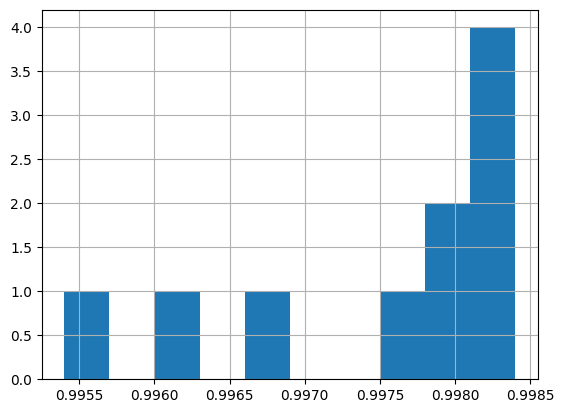

In [12]:
pd.Series(portfolio_values).hist();

### Insurance dropout

Simulation with InsuranceDropoutEvent

In [13]:
# Additional param
dropout_time = 3

In [14]:

sim_result = run_simulation(
    random_numbers=None,    # No copula applied
    assets_df=assets_processed,          # Independent assets
    firms=firms,
    portfolio=portfolio,
    simulations=simulations,
    time_horizon=25,
    seed=random_seed,
    insured=True,            # Insurance included
    insurer_capital=insurer_capital,
    dropout_time=dropout_time,  # Insurance dropout after specified time
    calculate_pds=False,        # No PD calculations
)

portfolio_values = sim_result["portfolio_values"]


Simulating No Copula:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating No Copula: 100%|██████████| 10/10 [00:00<00:00, 11.16it/s]


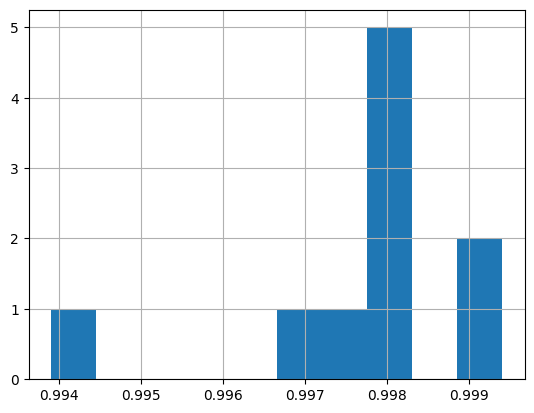

In [15]:
pd.Series(portfolio_values).hist();

### Merton Defaults and Insurance without dropout

In [16]:
# additional param
sigma=0.2

In [17]:
# Scenario 4: Complete Independence with Merton PD Calculations
sim_result = run_simulation(
    random_numbers=None,    # No copula applied
    assets_df=assets_processed,          # Independent assets
    firms=firms,
    portfolio=portfolio,
    simulations=simulations,
    time_horizon=25,
    seed=random_seed,
    insured=True,            # Insurance included
    insurer_capital=insurer_capital,
    dropout_time=None,        # No dropout
    calculate_pds=True,        # Enable PD calculations
    sigma=sigma                    # Volatility parameter for Merton model
)

# Extract PDs
empirical_independence = sim_result["empirical_pds"].values.tolist()
merton_independence = sim_result["merton_pds"].values.tolist()

# Extract portfolio values if needed
portfolio_values_4 = sim_result["portfolio_values"]


Simulating No Copula: 100%|██████████| 10/10 [00:01<00:00,  7.56it/s]


## 2. Basin-Level dependence
First, we start up by linking the asset locations to a specific basin. The geopandas package is used.

In [18]:
assets_with_basins, basins_processed = link_basins(assets_processed, basins=basins, country_basins=country_basins);

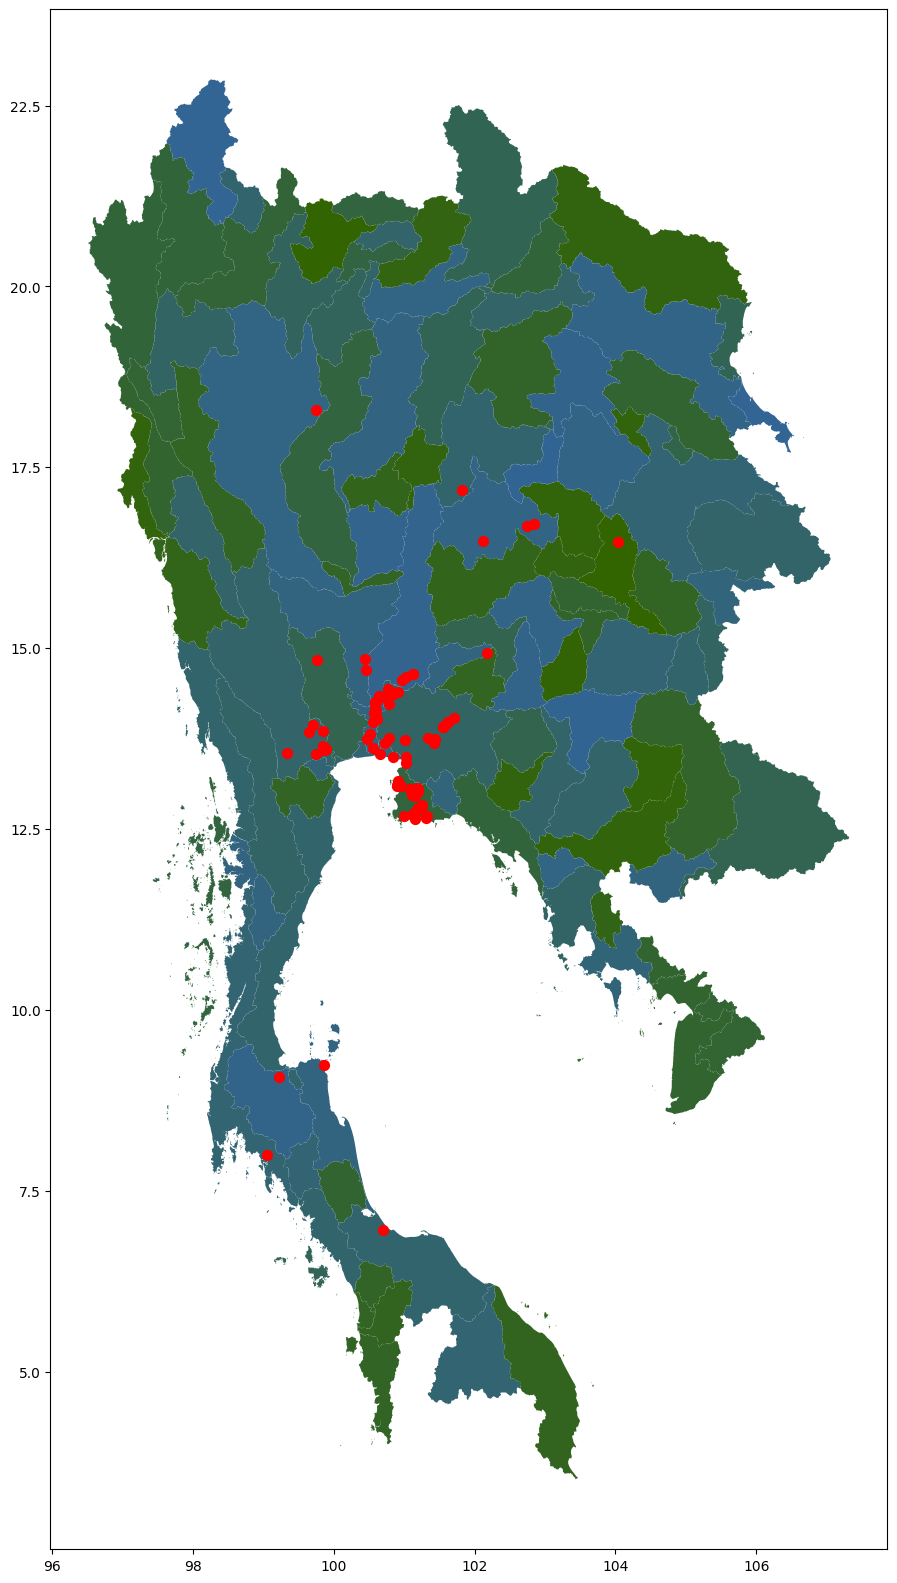

In [19]:
plot_assets_and_basins(assets_with_basins=assets_with_basins, basins_processed=basins_processed)

Once the basins are obtained, we simulate events at the basin level and incorporate it into the simulation:

### Kernel insurance

In [20]:
# Scenario 5: Basin-Level Dependence without Insurance
# Assuming 'vine_random_numbers' corresponds to the desired copula type for basin-level dependence
sim_result = run_simulation(
    random_numbers=random_numbers,  # Copula applied (e.g., 'vine')
    assets_df=assets_with_basins,            # Basin-linked assets
    firms=firms,
    portfolio=portfolio,
    simulations=simulations,
    time_horizon=25,
    seed=random_seed,
    insured=False,                        # No insurance
    insurer_capital=insurer_capital,
    dropout_time=None,                    # No dropout
    calculate_pds=False,                  # No PD calculations
    return_period_columns=return_period_columns # used only if random_numbers is not None i.e. copula applied
)

# Extract portfolio values
portfolio_values = sim_result["portfolio_values"]


Simulating With Copula:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating With Copula: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


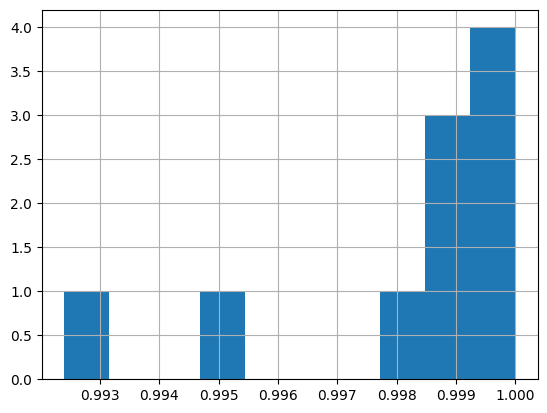

In [21]:
pd.Series(portfolio_values).hist();

### Insured CapDam

Simulation with simple Insurance

In [23]:
# Scenario 6: Basin-Level Dependence with Insurance
# Assuming 'gaussian_random_numbers' corresponds to the desired copula type for basin-level dependence
sim_result = run_simulation(
    random_numbers=random_numbers,  # Copula applied (e.g., 'gaussian')
    assets_df=assets_with_basins,                # Basin-linked assets
    firms=firms,
    portfolio=portfolio,
    simulations=simulations,
    time_horizon=25,
    seed=random_seed,
    insured=True,                              # Insurance included
    insurer_capital=insurer_capital,
    dropout_time=None,                          # No dropout
    calculate_pds=False,                        # No PD calculations
    return_period_columns=return_period_columns # used only if random_numbers is not None i.e. copula applied

)

# Extract portfolio values
portfolio_values = sim_result["portfolio_values"]


Simulating With Copula: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


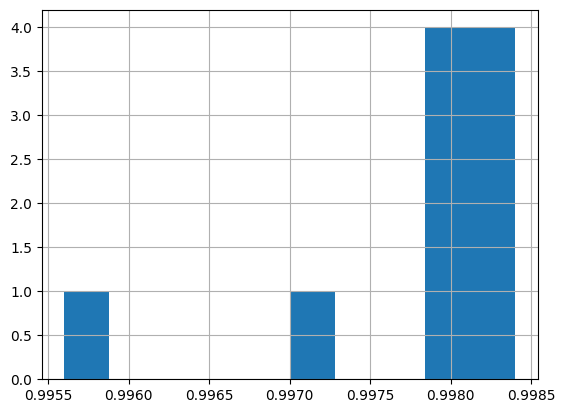

In [24]:
pd.Series(portfolio_values).hist();

### Insurance dropout

Simulation with InsuranceDropoutEvent

In [26]:
# Scenario 7: Basin-Level Dependence with Insurance Dropout
dropout_time = 3  # Define dropout time as per your setup

# Assuming 't_random_numbers' corresponds to the desired copula type for basin-level dependence
sim_result = run_simulation(
    random_numbers=random_numbers,           # Copula applied (e.g., 't')
    assets_df=assets_with_basins,                  # Basin-linked assets
    firms=firms,
    portfolio=portfolio,
    simulations=simulations,
    time_horizon=25,
    seed=random_seed,
    insured=True,                                # Insurance included
    insurer_capital=insurer_capital,
    dropout_time=dropout_time,                    # Insurance dropout after specified time
    calculate_pds=False,                          # No PD calculations
    return_period_columns=return_period_columns # used only if random_numbers is not None i.e. copula applied
)

# Extract portfolio values
portfolio_values = sim_result["portfolio_values"]


Simulating With Copula:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating With Copula: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


### Merton Defaults and Insurance without dropout

In [27]:
# additional param
sigma=0.2

In [29]:
# Scenario 8: Basin-Level Dependence with Merton PD Calculations
# Assuming 'complete_dependent_random_numbers' corresponds to the desired copula type for basin-level dependence
sim_result = run_simulation(
    random_numbers=random_numbers,  # Copula applied (e.g., 'complete_dependent')
    assets_df=assets_with_basins,                            # Basin-linked assets
    firms=firms,
    portfolio=portfolio,
    simulations=simulations,
    time_horizon=25,
    seed=random_seed,
    insured=True,                                        # Insurance included
    insurer_capital=insurer_capital,
    dropout_time=None,                                    # No dropout
    calculate_pds=True,                                    # Enable PD calculations
    sigma=0.2,                                              # Volatility parameter for Merton model
    return_period_columns=return_period_columns # used only if random_numbers is not None i.e. copula applied
)

# Extract PDs
empirical_independent_basins = sim_result["empirical_pds"].values.tolist()
merton_independent_basins = sim_result["merton_pds"].values.tolist()

# Extract portfolio values if needed
portfolio_values = sim_result["portfolio_values"]


Simulating With Copula:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating With Copula:  80%|████████  | 8/10 [00:05<00:01,  1.60it/s]

# Summary of results

In [ ]:
# Define your data
data_dict = {
    "Gaussian Copula": gaus,
    "Basin-Level Dependence": independent,
    "Complete Independence": asset_level
}

# Define colors for histograms
colors = ["blue", "orange", "black"]

# Define quantiles for reference lines
quantiles = {
    "Gaussian Copula": gaus_q5,
    "Basin-Level Dependence": independent_q5,
    "Complete Independence": asset_q5
}

# Generate the histogram
compare_value_distributions(
    data_dict=data_dict,
    bins=20,
    colors=colors,
    labels=list(data_dict.keys()),
    alpha=0.5,
    density=True,
    quantiles=quantiles,
    xlim=(0.96, 1),
    xlabel="Portfolio Value",
    title="Portfolio Value Distribution - Dependency Models",
    hide_yaxis=True,
    font_size=14,
    font_family="Times New Roman",
    save_path="portfolio_value_distribution_1.png"
)


## 1. Simulations

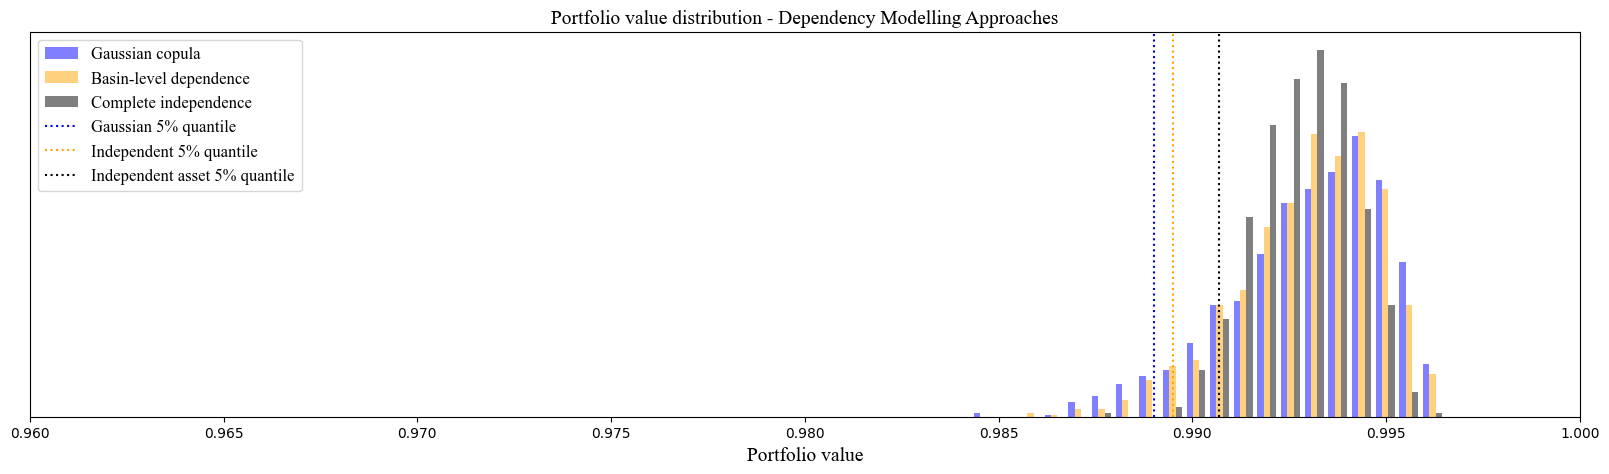

In [ ]:
import matplotlib.font_manager as font_manager

font_man = font_manager.FontProperties(family='Times New Roman',
                                   style='normal', size=12)

asset_level = pd.Series(portfolio_values)
gaus = pd.Series(portfolio_values_gaussian_basins)
vine = pd.Series(portfolio_values_vine_basins)
independent = pd.Series(portfolio_values_independent_basins)
dependent = pd.Series(portfolio_values_complete_dependent_basins)
t_dist = pd.Series(portfolio_values_t_basins)
plt.figure(figsize=(20, 5))
plt.hist([gaus, independent, asset_level], bins=20,
         color=["blue", "orange", "black"],
         label=["Gaussian copula" , "Basin-level dependence", "Complete independence"], alpha=0.5, density=True)
gaus_q5 = gaus.quantile(0.05)
t_dist_q5 = t_dist.quantile(0.05)
vine_q5 = vine.quantile(0.05)
independent_q5 = independent.quantile(0.05)
asset_q5 = asset_level.quantile(0.05)
dependent_q5 = dependent.quantile(0.05)
gaus_q1 = gaus.quantile(0.01)
t_dist_q1 = t_dist.quantile(0.01)
vine_q1 = vine.quantile(0.01)
independent_q1 = independent.quantile(0.01)
asset_q1 = asset_level.quantile(0.01)
dependent_q1 = dependent.quantile(0.01)
gaus_mean = gaus.mean()
t_dist_mean = t_dist.mean()
vine_mean = vine.mean()
independent_mean = independent.mean()
asset_mean = asset_level.mean()
dependent_mean = dependent.mean()
font = {"size": 14, "name": "times new roman"}
plt.axvline(gaus_q5, color="blue", linestyle=":", label="Gaussian 5% quantile")
#plt.axvline(t_dist_q5, color="red", linestyle=":", label="T 5% quantile")
#plt.axvline(vine_q5, color="green", linestyle=":", label="Vine 5% quantile")
plt.axvline(independent_q5, color="orange", linestyle=":", label="Independent 5% quantile")
plt.axvline(asset_q5, color="black", linestyle=":", label="Independent asset 5% quantile")
#plt.axvline(dependent_q5, color="purple", linestyle=":", label="Complete dependent 5% quantile")
plt.xlabel("Portfolio value", fontdict=font)
plt.xlim(0.96, 1)
plt.title("Portfolio value distribution - Dependency Modelling Approaches", fontdict=font)
plt.legend(prop=font_man)
# Hide y-axis
plt.gca().axes.get_yaxis().set_visible(False)
#plt.savefig('portfolio_value_distribution_1.png', transparent=True)

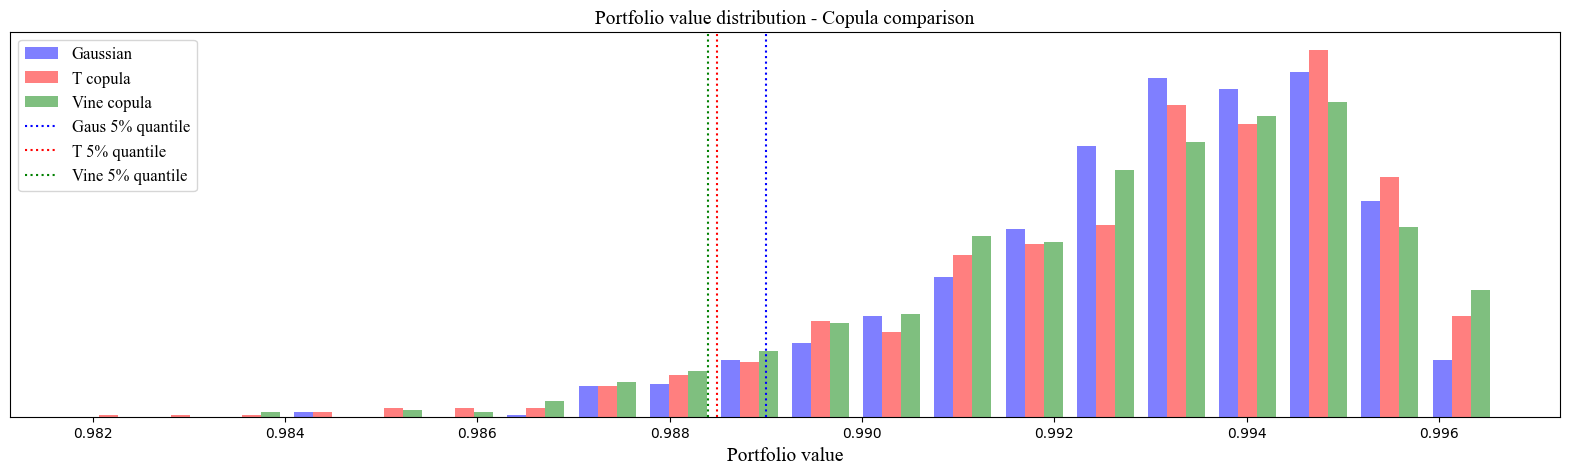

In [ ]:
plt.figure(figsize=(20, 5))
plt.hist([gaus, t_dist, vine], bins=20,
         color=["blue", "red", "green"],
         label=["Gaussian" , "T copula", "Vine copula"], alpha=0.5, density=True)
font = {"size": 14, "name": "times new roman"}
plt.axvline(gaus_q5, color="blue", linestyle=":", label="Gaus 5% quantile")
plt.axvline(t_dist_q5, color="red", linestyle=":", label="T 5% quantile")
plt.axvline(vine_q5, color="green", linestyle=":", label="Vine 5% quantile")
#plt.axvline(independent_q5, color="yellow", linestyle=":", label="Independent 1% quantile")
#plt.axvline(asset_q5, color="blue", linestyle=":", label="Independent asset 1% quantile")
plt.xlabel("Portfolio value", fontdict=font)
#plt.xlim(0.96, 1)
plt.title("Portfolio value distribution - Copula comparison", fontdict=font)
plt.legend(prop=font_man)
plt.gca().axes.get_yaxis().set_visible(False)
#plt.savefig('portfolio_value_distribution.png', transparent=True)

Boxplots

/var/folders/zz/zvsv6f4s4wn29k9lt76bdlsr0000gn/T/ipykernel_38310/403043550.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().axes.set_xticklabels(["", "Complete Independence", "Basin-Level Independence", "Gaussian Copula", "T-Copula", "Vine Copula", "Complete dependence"], fontdict=font)


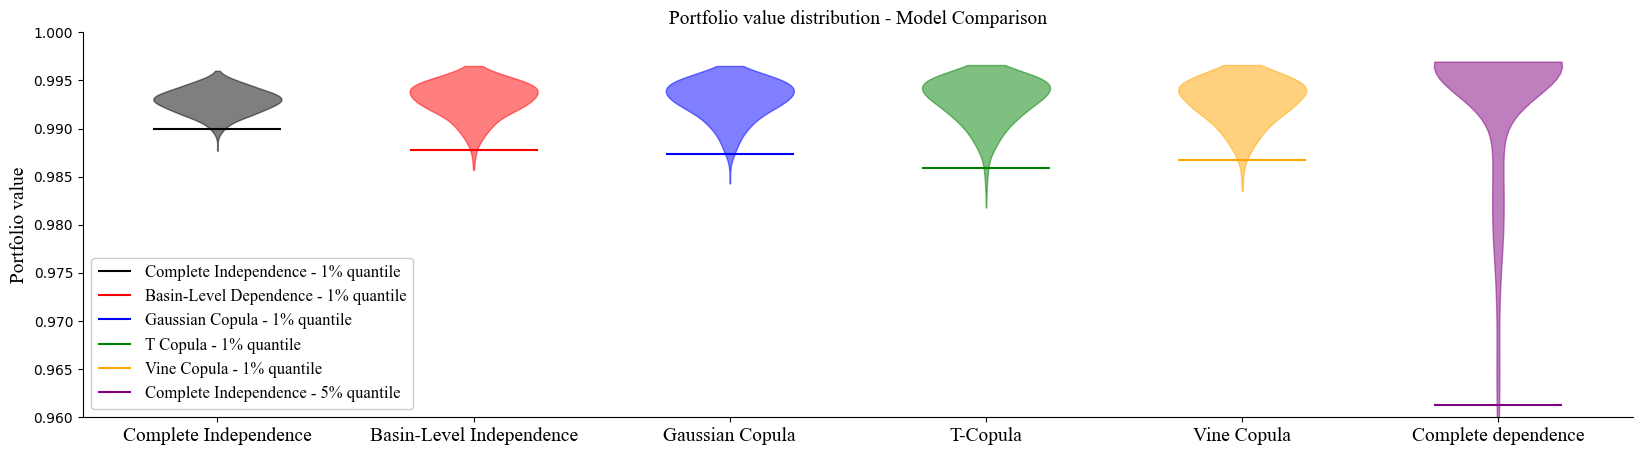

In [ ]:
plt.figure(figsize=(20, 5))
vp = plt.violinplot(
    [asset_level, independent, gaus, t_dist, vine, dependent], 
    showmeans=False,
    showextrema=False,
    bw_method=0.4
    );
plt.hlines(asset_q1, 0.75, 1.25, color="black", label="Complete Independence - 1% quantile")
plt.hlines(independent_q1, 1.75, 2.25, color="red", label="Basin-Level Dependence - 1% quantile")
plt.hlines(gaus_q1, 2.75, 3.25, color="blue", label="Gaussian Copula - 1% quantile")
plt.hlines(t_dist_q1, 3.75, 4.25, color="green", label="T Copula - 1% quantile")
plt.hlines(vine_q1, 4.75, 5.25, color="orange", label="Vine Copula - 1% quantile")
plt.hlines(dependent_q1, 5.75, 6.25, color="purple",  label="Complete Independence - 5% quantile")
legend = plt.legend(loc="lower left", prop=font_man)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0.0))
colors = ["black", "red", "blue", "green", "orange", "purple"]
plt.ylabel("Portfolio value", fontdict=font)

for i, pc in enumerate(vp["bodies"]):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor(colors[i])
    pc.set_alpha(0.5)

plt.ylim(0.96, 1)
plt.gca().axes.set_xticklabels(["", "Complete Independence", "Basin-Level Independence", "Gaussian Copula", "T-Copula", "Vine Copula", "Complete dependence"], fontdict=font)
plt.title("Portfolio value distribution - Model Comparison", fontdict=font)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
#plt.savefig('portfolio_value_distribution_violin.png', transparent=True)


In [ ]:
pd.DataFrame(
    {
        "Average Impact":   [asset_mean, independent_mean, gaus_mean, t_dist_mean, vine_mean, dependent_mean],
        "Median Impact":    [asset_level.median(), independent.median(), gaus.median(), t_dist.median(), vine.median(), dependent.median()],
        "Q10":              [asset_level.quantile(0.1), independent.quantile(0.1), gaus.quantile(0.1), t_dist.quantile(0.1), vine.quantile(0.1), dependent.quantile(0.1)],
        "Q5":               [asset_q5, independent_q5, gaus_q5, t_dist_q5, vine_q5, dependent_q5],
        "Q1":               [asset_q1, independent_q1, gaus_q1, t_dist_q1, vine_q1, dependent_q1]
    },
    index=["Complete Independence", "Basin-level independence", "Gaussian copula", "T copula", "Vine copula", "Complete dependence"]
)*100 - 100


,Average Impact,Median Impact,Q10,Q5,Q1
Complete Independence,-0.71599,-0.71,-0.880,-0.9300,-1.0100
Basin-level independence,-0.69993,-0.68,-0.960,-1.0500,-1.2201
Gaussian copula,-0.70158,-0.67,-0.990,-1.1000,-1.2601
T copula,-0.70581,-0.66,-1.031,-1.1505,-1.4102
Vine copula,-0.71750,-0.68,-1.050,-1.1600,-1.3300
Complete dependence,-0.67105,-0.35,-1.821,-2.3620,-3.8717


#### Bootstraps

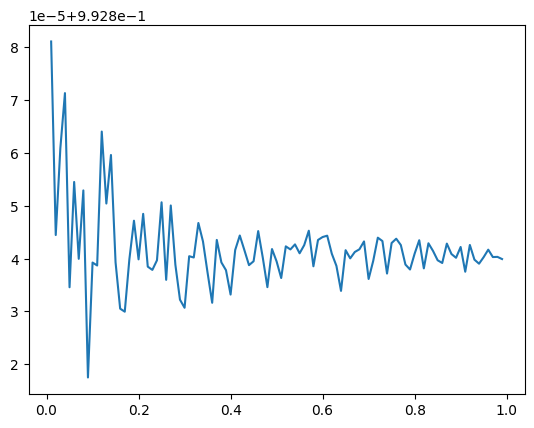

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# We will use subsampling without replacement to create the bootstrap distribution
# https://www.stat.berkeley.edu/~bickel/BS2008SS.pdf
# we try out bootstrapping for various values of m and check when the results are 
# stable
def get_bootstraps_m(data, m_values):
    means, variances = [], []
    for m in m_values:
        bootstrapped_means = []
        for i in range(100):
            sample = np.random.choice(data, size=int(len(t_dist)*m), replace=False)
            bootstrapped_means.append(sample.mean())
        means.append(np.mean(bootstrapped_means))
        variances.append(np.std(bootstrapped_means))
    return means, variances

def boostrap_q(data, q=0.95, m=0.6):
    bootstrapped_q = []
    for i in range(100):
        sample = np.random.choice(data, size=int(len(t_dist)*m), replace=False)
        bootstrapped_q.append(np.quantile(sample, q))
    return round(np.mean(bootstrapped_q), 6), round(np.quantile(bootstrapped_q, 0.05), 6), round(np.quantile(bootstrapped_q, 0.95),6)

m_values = np.arange(1, 100, 1)/100
means, variances = get_bootstraps_m(portfolio_values, m_values)
plt.plot(m_values, means); # Seems to become stable at 0.4 -> so we pick m equal to 0.75

/var/folders/zz/zvsv6f4s4wn29k9lt76bdlsr0000gn/T/ipykernel_38310/1344505536.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().axes.set_xticklabels(["", "Complete Independence", "Basin-Level Independence", "Gaussian Copula", "Vine Copula", "T-Copula", "Complete dependence"], fontdict=font)


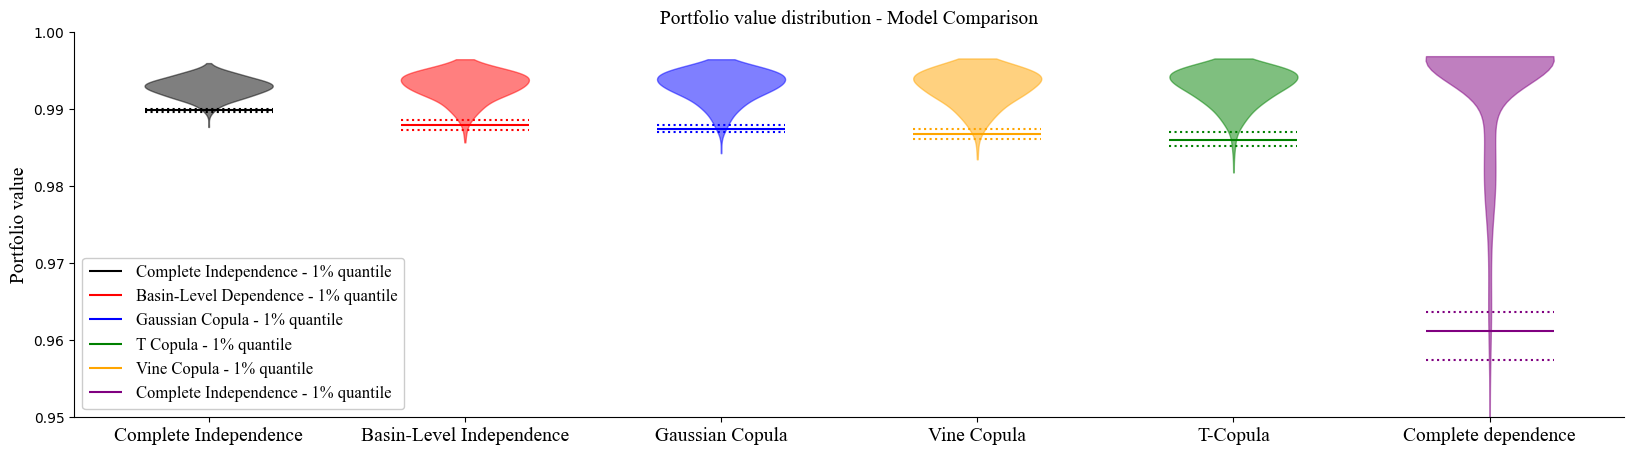

In [ ]:
m=0.4
asset_q1, asset_lb, asset_up = boostrap_q(portfolio_values, q=0.01, m=m)
independent_q1, independent_lb, independent_up = boostrap_q(portfolio_values_independent_basins, q=0.01, m=m)
gaus_q1, gaus_lb, gaus_up = boostrap_q(portfolio_values_gaussian_basins, q=0.01, m=m)
t_dist_q1, t_dist_lb, t_dist_up = boostrap_q(portfolio_values_t_basins, q=0.01, m=m)
vine_q1, vine_lb, vine_up = boostrap_q(portfolio_values_vine_basins, q=0.01, m=m)
dependent_q1, dependent_lb, dependent_up = boostrap_q(portfolio_values_complete_dependent_basins, q=0.01, m=m)

asset_q5, asset_lb5, asset_up5 = boostrap_q(portfolio_values, q=0.05, m=m)
independent_q5, independent_lb5, independent_up5 = boostrap_q(portfolio_values_independent_basins, q=0.05, m=m)
gaus_q5, gaus_lb5, gaus_up5 = boostrap_q(portfolio_values_gaussian_basins, q=0.05, m=m)
t_dist_q5, t_dist_lb5, t_dist_up5 = boostrap_q(portfolio_values_t_basins, q=0.05, m=m)
vine_q5, vine_lb5, vine_up5 = boostrap_q(portfolio_values_vine_basins, q=0.05, m=m)
dependent_q5, dependent_lb5, dependent_up5 = boostrap_q(portfolio_values_complete_dependent_basins, q=0.05, m=m)

plt.figure(figsize=(20, 5))
vp = plt.violinplot(
    [asset_level, independent, gaus, vine, t_dist, dependent], 
    showmeans=False,
    showextrema=False,
    bw_method=0.4
    );
plt.hlines(asset_q1, 0.75, 1.25, color="black", label="Complete Independence - 1% quantile")
plt.hlines(independent_q1, 1.75, 2.25, color="red", label="Basin-Level Dependence - 1% quantile")
plt.hlines(gaus_q1, 2.75, 3.25, color="blue", label="Gaussian Copula - 1% quantile")
plt.hlines(t_dist_q1, 4.75, 5.25, color="green", label="T Copula - 1% quantile")
plt.hlines(vine_q1, 3.75, 4.25, color="orange", label="Vine Copula - 1% quantile")
plt.hlines(dependent_q1, 5.75, 6.25, color="purple",  label="Complete Independence - 1% quantile")
plt.hlines(asset_lb, 0.75, 1.25, color="black", linestyle=":")
plt.hlines(independent_lb, 1.75, 2.25, color="red", linestyle=":")
plt.hlines(gaus_lb, 2.75, 3.25, color="blue", linestyle=":")
plt.hlines(t_dist_lb, 4.75, 5.25, color="green", linestyle=":")
plt.hlines(vine_lb, 3.75, 4.25, color="orange", linestyle=":")
plt.hlines(dependent_lb, 5.75, 6.25, color="purple", linestyle=":")
plt.hlines(asset_up, 0.75, 1.25, color="black", linestyle=":")
plt.hlines(independent_up, 1.75, 2.25, color="red", linestyle=":")
plt.hlines(gaus_up, 2.75, 3.25, color="blue", linestyle=":")
plt.hlines(t_dist_up, 4.75, 5.25, color="green", linestyle=":")
plt.hlines(vine_up, 3.75, 4.25, color="orange", linestyle=":")
plt.hlines(dependent_up, 5.75, 6.25, color="purple", linestyle=":")

legend = plt.legend(loc="lower left", prop=font_man)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0.0))
colors = ["black", "red", "blue", "orange","green", "purple"]
plt.ylabel("Portfolio value", fontdict=font)

for i, pc in enumerate(vp["bodies"]):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor(colors[i])
    pc.set_alpha(0.5)
plt.ylim(0.95, 1)

plt.gca().axes.set_xticklabels(["", "Complete Independence", "Basin-Level Independence", "Gaussian Copula", "Vine Copula", "T-Copula", "Complete dependence"], fontdict=font)
plt.title("Portfolio value distribution - Model Comparison", fontdict=font)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.savefig('portfolio_value_distribution_violin_capdam.png', transparent=True)

In [ ]:
table = pd.DataFrame(
    {
        "Average Impact":   [asset_mean, independent_mean, gaus_mean, t_dist_mean, vine_mean, dependent_mean],
        "Median Impact":    [asset_level.median(), independent.median(), gaus.median(), t_dist.median(), vine.median(), dependent.median()],
        "Q5":               [asset_q5, independent_q5, gaus_q5, t_dist_q5, vine_q5, dependent_q5],
        "Q1":               [asset_q1, independent_q1, gaus_q1, t_dist_q1, vine_q1, dependent_q1],
    },
    index=["Complete Independence", "Basin-level independence", "Gaussian copula", "T copula", "Vine copula", "Complete dependence"]
)
table = (table-1)*100
table.loc[:, "Q5 Interval"] = [f"[{round((asset_up5-1)*100, 2)}, {round((asset_lb5-1)*100, 2)}]",
                               f"[{round((independent_up5-1)*100, 2)}, {round((independent_lb5-1)*100, 2)}]",
                               f"[{round((gaus_up5-1)*100, 2)}, {round((gaus_lb5-1)*100, 2)}]",
                               f"[{round((t_dist_up5-1)*100, 2)}, {round((t_dist_lb5-1)*100, 2)}]",
                               f"[{round((vine_up5-1)*100, 2)}, {round((vine_lb5-1)*100, 2)}]",
                               f"[{round((dependent_up5-1)*100, 2)}, {round((dependent_lb5-1)*100, 2)}]"]
table.loc[:, "Q1 Interval"] = [f"[{round((asset_up-1)*100, 2)}, {round((asset_lb-1)*100, 2)}]",
                               f"[{round((independent_up-1)*100, 2)}, {round((independent_lb-1)*100, 2)}]",
                               f"[{round((gaus_up-1)*100, 2)}, {round((gaus_lb-1)*100, 2)}]",
                               f"[{round((t_dist_up-1)*100, 2)}, {round((t_dist_lb-1)*100, 2)}]",
                               f"[{round((vine_up-1)*100, 2)}, {round((vine_lb-1)*100, 2)}]",
                               f"[{round((dependent_up-1)*100, 2)}, {round((dependent_lb-1)*100, 2)}]"]
table

,Average Impact,Median Impact,Q5,Q1,Q5 Interval,Q1 Interval
Complete Independence,-0.71599,-0.71,-0.9270,-1.0132,"[-0.91, -0.94]","[-0.99, -1.06]"
Basin-level independence,-0.69993,-0.68,-1.0451,-1.2036,"[-1.02, -1.07]","[-1.15, -1.27]"
Gaussian copula,-0.70158,-0.67,-1.1029,-1.2559,"[-1.05, -1.14]","[-1.21, -1.29]"
T copula,-0.70581,-0.66,-1.1468,-1.3964,"[-1.09, -1.18]","[-1.28, -1.47]"
Vine copula,-0.71750,-0.68,-1.1546,-1.3235,"[-1.12, -1.18]","[-1.28, -1.38]"
Complete dependence,-0.67105,-0.35,-2.3758,-3.8626,"[-2.08, -2.7]","[-3.54, -4.26]"


## 2. Merton PDs

In [ ]:

empirical_avg_independent = [np.nanmean(emp) for emp in empirical_independence]
merton_avg_independent = [np.nanmean(mert) for mert in merton_independence]

empirical_avg_basin = [np.nanmean(emp) for emp in empirical_independent_basins]
merton_avg_basin = [np.nanmean(mert) for mert in merton_independent_basins]

empirical_avg_gaussian = [np.nanmean(emp) for emp in empirical_gaussian]
merton_avg_gaussian = [np.nanmean(mert) for mert in merton_gaussian]

empirical_avg_t = [np.nanmean(emp) for emp in empirical_t]
merton_avg_t = [np.nanmean(mert) for mert in merton_t]

empirical_avg_vine = [np.nanmean(emp) for emp in empirical_vine]
merton_avg_vine = [np.nanmean(mert) for mert in merton_vine]

empirical_avg_dependent = [np.nanmean(emp) for emp in empirical_dependent]
merton_avg_dependent = [np.nanmean(mert) for mert in merton_dependent]

empirical_q95_independent = np.quantile(empirical_avg_independent, 0.95)
merton_q95_independent = np.quantile(merton_avg_independent, 0.95)
empirical_q99_independent = np.quantile(empirical_avg_independent, 0.99)
merton_q99_independent = np.quantile(merton_avg_independent, 0.99)

empirical_q95_basin = np.quantile(empirical_avg_basin, 0.95)
merton_q95_basin = np.quantile(merton_avg_basin, 0.95)
empirical_q99_basin = np.quantile(empirical_avg_basin, 0.99)
merton_q99_basin = np.quantile(merton_avg_basin, 0.99)

empirical_q95_gaussian = np.quantile(empirical_avg_gaussian, 0.95)
merton_q95_gaussian = np.quantile(merton_avg_gaussian, 0.95)
empirical_q99_gaussian = np.quantile(empirical_avg_gaussian, 0.99)
merton_q99_gaussian = np.quantile(merton_avg_gaussian, 0.99)

empirical_q95_t = np.quantile(empirical_avg_t, 0.95)
merton_q95_t = np.quantile(merton_avg_t, 0.95)
empirical_q99_t = np.quantile(empirical_avg_t, 0.99)
merton_q99_t = np.quantile(merton_avg_t, 0.99)

empirical_q95_vine = np.quantile(empirical_avg_vine, 0.95)
merton_q95_vine = np.quantile(merton_avg_vine, 0.95)
empirical_q99_vine = np.quantile(empirical_avg_vine, 0.99)
merton_q99_vine = np.quantile(merton_avg_vine, 0.99)

empirical_q95_dependent = np.quantile(empirical_avg_dependent, 0.95)
merton_q95_dependent = np.quantile(merton_avg_dependent, 0.95)
empirical_q99_dependent = np.quantile(empirical_avg_dependent, 0.99)
merton_q99_dependent = np.quantile(merton_avg_dependent, 0.99)

empirical_q50_independent = np.quantile(empirical_avg_independent, 0.5)
merton_q50_independent = np.quantile(merton_avg_independent, 0.5)
empirical_average_independent = np.mean(empirical_avg_independent)
merton_average_independent = np.mean(merton_avg_independent)

empirical_q50_basin = np.quantile(empirical_avg_basin, 0.5)
merton_q50_basin = np.quantile(merton_avg_basin, 0.5)
empirical_average_basin = np.mean(empirical_avg_basin)
merton_average_basin = np.mean(merton_avg_basin)

empirical_q50_gaussian = np.quantile(empirical_avg_gaussian, 0.5)
merton_q50_gaussian = np.quantile(merton_avg_gaussian, 0.5)
empirical_average_gaussian = np.mean(empirical_avg_gaussian)
merton_average_gaussian = np.mean(merton_avg_gaussian)

empirical_q50_t = np.quantile(empirical_avg_t, 0.5)
merton_q50_t = np.quantile(merton_avg_t, 0.5)
empirical_average_t = np.mean(empirical_avg_t)
merton_average_t = np.mean(merton_avg_t)

empirical_q50_vine = np.quantile(empirical_avg_vine, 0.5)
merton_q50_vine = np.quantile(merton_avg_vine, 0.5)
empirical_average_vine = np.mean(empirical_avg_vine)
merton_average_vine = np.mean(merton_avg_vine)

empirical_q50_dependent = np.quantile(empirical_avg_dependent, 0.5)
merton_q50_dependent = np.quantile(merton_avg_dependent, 0.5)
empirical_average_dependent = np.mean(empirical_avg_dependent)
merton_average_dependent = np.mean(merton_avg_dependent)

empirical_results = pd.DataFrame({
    "Average Impact": [empirical_average_independent, empirical_average_basin, empirical_average_gaussian, empirical_average_t, empirical_average_vine, empirical_average_dependent],
    "Median Impact": [empirical_q50_independent, empirical_q50_basin, empirical_q50_gaussian, empirical_q50_t, empirical_q50_vine, empirical_q50_dependent],
    "95th percentile": [empirical_q95_independent, empirical_q95_basin, empirical_q95_gaussian, empirical_q95_t, empirical_q95_vine, empirical_q95_dependent],
    "99th percentile": [empirical_q99_independent, empirical_q99_basin, empirical_q99_gaussian, empirical_q99_t, empirical_q99_vine, empirical_q99_dependent],
}, index=["Complete independence", "Basin-level independence", 
          "Gaussian copula", "T copula", "Vine copula", "Complete dependence"]) * 1000

merton_results = pd.DataFrame({
    "Average Impact": [merton_average_independent, merton_average_basin, merton_average_gaussian, merton_average_t, merton_average_vine, merton_average_dependent],
    "Median Impact": [merton_q50_independent, merton_q50_basin, merton_q50_gaussian, merton_q50_t, merton_q50_vine, merton_q50_dependent],
    "95th percentile": [merton_q95_independent, merton_q95_basin, merton_q95_gaussian, merton_q95_t, merton_q95_vine, merton_q95_dependent],
    "99th percentile": [merton_q99_independent, merton_q99_basin, merton_q99_gaussian, merton_q99_t, merton_q99_vine, merton_q99_dependent],
}, index=["Complete independence", "Basin-level independence", 
          "Gaussian copula", "T copula", "Vine copula", "Complete dependence"]) * 1000




In [ ]:
empirical_results
    

,Average Impact,Median Impact,95th percentile,99th percentile
Complete independence,2.427581,2.351657,3.916751,4.793613
Basin-level independence,2.296293,2.105603,4.753375,6.563792
Gaussian copula,2.342580,2.086982,4.886011,6.798184
T copula,2.391865,2.027901,5.227664,7.215472
Vine copula,2.391865,2.027901,5.227664,7.215472
Complete dependence,2.376268,0.264190,14.197431,25.497104


In [ ]:
merton_results.to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n & Average Impact & Median Impact & 95th percentile & 99th percentile \\\\\n\\midrule\nComplete independence & 3.215419 & 2.789105 & 6.981805 & 8.797749 \\\\\nBasin-level independence & 3.031876 & 2.297572 & 7.996213 & 11.157796 \\\\\nGaussian copula & 3.117071 & 2.288987 & 8.395543 & 13.425415 \\\\\nT copula & 3.247501 & 2.305818 & 9.627927 & 13.967070 \\\\\nVine copula & 3.247501 & 2.305818 & 9.627927 & 13.967070 \\\\\nComplete dependence & 3.216539 & 0.088155 & 21.113898 & 41.622030 \\\\\n\\bottomrule\n\\end{tabular}\n'

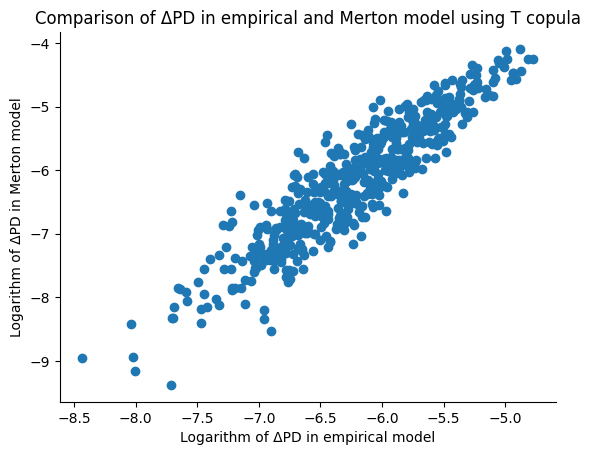

In [ ]:
plt.scatter(np.log(empirical_avg_t), np.log(merton_avg_t))
plt.xlabel("Logarithm of ΔPD in empirical model")
plt.ylabel("Logarithm of ΔPD in Merton model")
plt.title("Comparison of ΔPD in empirical and Merton model using T copula")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.savefig('log_pds.png', transparent=True)

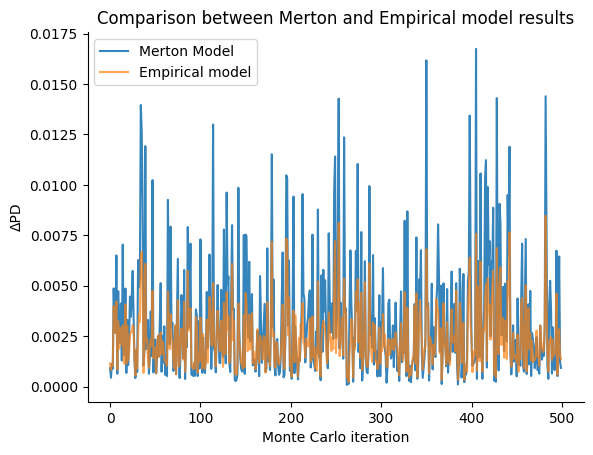

In [ ]:
plt.plot(merton_avg_t, label="Merton Model", alpha=0.9)
plt.plot(empirical_avg_t, label="Empirical model", alpha=0.7)

plt.xlabel("Monte Carlo iteration")
plt.ylabel("ΔPD")
plt.title("Comparison between Merton and Empirical model results")
plt.legend()

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.savefig('sim_pds.png', transparent=True)